In [112]:
# implementation of probabilistic matrix factorisation

%load_ext autoreload
%autoreload 2

from utils import *

import pickle
import random
import numpy as np
from scipy.sparse import csr_matrix, save_npz, load_npz
from tqdm.notebook import tqdm
from itertools import chain
from collections import Counter, defaultdict
from pathlib import Path
from sklearn import metrics
import csv
import tensorflow as tf
import math
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180

In [114]:
movieid_mid_lookup = get_movieid_mid_lookup(recompute=False)

In [115]:
# tags = set()
# max_tag, min_tag = 0, math.inf

# with open(movie_review_relevance, newline="") as csvfile:
#     reader = csv.DictReader(csvfile)
#     for rating in tqdm(reader):
# #         movieid = int(float(rating["movieId"]))
#         tagid = int(float(rating["tagId"]))
# #         relevance = float(rating["relevance"])
#         tags.add(tagid)
#         max_tag = max(max_tag, tagid)
#         min_tag = min(min_tag, tagid)

movie_tag_mids, movie_tag_relevances = get_movie_tag_relevances()
print(len(movie_tag_mids))



0it [00:00, ?it/s]

27868it [00:00, 278678.94it/s]

loading movie tags from csv




56716it [00:00, 281546.13it/s]

85008it [00:00, 281954.56it/s]

113742it [00:00, 283548.55it/s]

141927it [00:00, 283035.70it/s]

170438it [00:00, 283654.29it/s]

199288it [00:00, 285088.09it/s]

228213it [00:00, 286322.49it/s]

257027it [00:00, 286863.37it/s]

285463it [00:01, 286107.41it/s]

313379it [00:01, 283986.20it/s]

341233it [00:01, 282304.20it/s]

369153it [00:01, 281364.78it/s]

397395it [00:01, 281680.20it/s]

426104it [00:01, 283279.49it/s]

454492it [00:01, 283457.23it/s]

482855it [00:01, 283507.30it/s]

511559it [00:01, 284555.60it/s]

540322it [00:01, 285469.46it/s]

569240it [00:02, 286571.45it/s]

597878it [00:02, 283753.38it/s]

626546it [00:02, 284624.14it/s]

655348it [00:02, 285633.13it/s]

684055it [00:02, 286060.11it/s]

712660it [00:02, 283908.25it/s]

741181it [00:02, 284294.97it/s]

769841it [00:02, 284981.44it/s]

798505it [00:02, 285474.43it/s]

827054it [00:02, 284511.18it/s]

855583it [00:03, 284742.02it/s]

884059it [00:03, 284050.25it/s]

913043it [

5887780it [00:20, 284286.59it/s]

5916213it [00:20, 284052.67it/s]

5944710it [00:20, 284326.11it/s]

5973161it [00:21, 284379.50it/s]

6001601it [00:21, 284280.01it/s]

6030030it [00:21, 283484.22it/s]

6058380it [00:21, 282530.80it/s]

6086866it [00:21, 283223.01it/s]

6115190it [00:21, 282525.79it/s]

6143445it [00:21, 282530.91it/s]

6171700it [00:21, 281580.71it/s]

6199892it [00:21, 281680.68it/s]

6228121it [00:21, 281862.07it/s]

6256651it [00:22, 282883.39it/s]

6285094it [00:22, 283342.66it/s]

6313430it [00:22, 282798.59it/s]

6341843it [00:22, 283195.57it/s]

6370164it [00:22, 282328.25it/s]

6398502it [00:22, 282640.82it/s]

6427026it [00:22, 283415.46it/s]

6455369it [00:22, 283266.13it/s]

6483826it [00:22, 283654.09it/s]

6512228it [00:22, 283763.04it/s]

6540605it [00:23, 280722.31it/s]

6568891it [00:23, 281358.50it/s]

6597280it [00:23, 282112.27it/s]

6625902it [00:23, 283330.83it/s]

6654240it [00:23, 282674.49it/s]

6682511it [00:23, 281718.91it/s]

6710687it [00:

11632302it [00:41, 280813.14it/s]

11660757it [00:41, 281922.73it/s]

11709768it [00:41, 282458.99it/s]


10381


In [121]:
# the model

assert embedding_dim > 20

movie_tag_relevances_var = tf.placeholder(dtype=tf.float64, shape=[None, NUM_TAGS])

W1 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[NUM_TAGS, 228], dtype=tf.float64))
b1 = tf.Variable(initial_value=np.zeros(shape=[228], dtype=np.float64))
l1 = tf.nn.relu(tf.matmul(movie_tag_relevances_var, W1) + b1)

W2 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[228, NUM_TAGS], dtype=tf.float64))
b2 = tf.Variable(initial_value=np.zeros(shape=[NUM_TAGS], dtype=np.float64))
pred_y = tf.nn.sigmoid(tf.matmul(l1, W2) + b2)

print(movie_tag_relevances_var.shape, pred_y.shape)

(?, 1128) (?, 1128)


In [123]:
train_relevances = movie_tag_relevances[1000:]
val_relevances = movie_tag_relevances[:1000]
print("num training examples", len(train_relevances))

plot_weights = True

learning_rate=.001
epochs=120

mse_loss_term = tf.reduce_mean(tf.squared_difference(pred_y, movie_tag_relevances_var))
loss = mse_loss_term

train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in tqdm(range(epochs), leave=False):
        val_loss_val = sess.run(loss, feed_dict={movie_tag_relevances_var: val_relevances})
        print("training")
        _, val_loss = sess.run((train_step, loss), feed_dict={movie_tag_relevances_var: train_relevances})
        print("train loss", val_loss)
#         print("l1 weights", sess.run(W4, feed_dict={movie_tag_relevances_var: train_relevances}))

        val_loss_val = sess.run(loss, feed_dict={movie_tag_relevances_var: val_relevances})

        print("val loss", val_loss_val)
        print("true", val_relevances[0])
        print("pred", sess.run(pred_y[0], feed_dict={movie_tag_relevances_var: val_relevances}))
        print("")

num training examples 9381


training
train loss 0.17233848126101514
val loss 0.1586846101321586
true [0.04575 0.05275 0.16675 0.08275 0.1145  0.15625 0.05025 0.11175 0.0395
 0.08    ... 0.0375  0.02825 0.012   0.03575 0.13    0.04875 0.01975
 0.0105  0.10925 0.0185 ]
pred [0.48326173 0.47939046 0.49156796 0.50282705 0.49952193 0.4928108
 0.50837794 0.49348668 0.52840389 0.49039594 ... 0.49828618 0.50080154
 0.49385919 0.50304697 0.47266649 0.48651573 0.51752446 0.47425885
 0.51651555 0.48827941]

training
train loss 0.16590376645175353
val loss 0.15032152435668664
true [0.04575 0.05275 0.16675 0.08275 0.1145  0.15625 0.05025 0.11175 0.0395
 0.08    ... 0.0375  0.02825 0.012   0.03575 0.13    0.04875 0.01975
 0.0105  0.10925 0.0185 ]
pred [0.45580305 0.46746763 0.4866983  0.4957996  0.48860718 0.47086309
 0.50169987 0.47629828 0.5270204  0.49506059 ... 0.49711255 0.48363573
 0.47444852 0.50182123 0.45387798 0.48312335 0.5009543  0.46003872
 0.5180845  0.47178928]

training
train loss 0.1582069168979818
val loss 0.

train loss 0.02280714293679906
val loss 0.0337040389307086
true [0.04575 0.05275 0.16675 0.08275 0.1145  0.15625 0.05025 0.11175 0.0395
 0.08    ... 0.0375  0.02825 0.012   0.03575 0.13    0.04875 0.01975
 0.0105  0.10925 0.0185 ]
pred [0.01086804 0.01089197 0.02294052 0.04003902 0.03358724 0.01235774
 0.0206601  0.03302506 0.02771161 0.02706433 ... 0.01847531 0.0228378
 0.0136263  0.01484659 0.20423831 0.02613259 0.03716521 0.01978214
 0.04443302 0.01474413]

training
train loss 0.02279074984410011
val loss 0.033364779957780345
true [0.04575 0.05275 0.16675 0.08275 0.1145  0.15625 0.05025 0.11175 0.0395
 0.08    ... 0.0375  0.02825 0.012   0.03575 0.13    0.04875 0.01975
 0.0105  0.10925 0.0185 ]
pred [0.00905906 0.00899716 0.01894794 0.03360505 0.0291012  0.01040568
 0.01713082 0.03102125 0.02331136 0.02264709 ... 0.01545772 0.01877097
 0.01127223 0.01237404 0.23866208 0.02210755 0.03048094 0.01618101
 0.03802501 0.01204082]

training
train loss 0.022736335852101257
val loss 0.032995

train loss 0.020687667693316338
val loss 0.029169408884425627
true [0.04575 0.05275 0.16675 0.08275 0.1145  0.15625 0.05025 0.11175 0.0395
 0.08    ... 0.0375  0.02825 0.012   0.03575 0.13    0.04875 0.01975
 0.0105  0.10925 0.0185 ]
pred [0.00276765 0.00236885 0.00537213 0.01026955 0.01818568 0.00389128
 0.00457131 0.08162941 0.00834649 0.00649094 ... 0.00485744 0.00452064
 0.00308966 0.00354247 0.25967112 0.0074619  0.00608532 0.00369662
 0.01758828 0.00277358]

training
train loss 0.020575221519390688
val loss 0.028996630258506403
true [0.04575 0.05275 0.16675 0.08275 0.1145  0.15625 0.05025 0.11175 0.0395
 0.08    ... 0.0375  0.02825 0.012   0.03575 0.13    0.04875 0.01975
 0.0105  0.10925 0.0185 ]
pred [0.0027343  0.00233227 0.00530406 0.01023295 0.01881019 0.00386522
 0.0045272  0.09505708 0.00834346 0.00644197 ... 0.00485191 0.00442433
 0.00305099 0.00351025 0.27613163 0.0074714  0.00592507 0.00360914
 0.01784065 0.00270769]

training
train loss 0.020465392865562704
val loss 0.0

KeyboardInterrupt: 

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

train_relevances = movie_tag_relevances[1000:]
val_relevances = movie_tag_relevances[:1000]

scaler = StandardScaler()
scaler.fit(train_relevances)
# Apply transform to both the training set and the test set.
train_relevances = scaler.transform(train_relevances)
val_relevances = scaler.transform(val_relevances)

[0.6, 0.7, 0.8, 0.82, 0.83, 0.84, 0.85]



[(0.6, 58, 0.39966983), (0.7, 121, 0.29934865), (0.8, 239, 0.19993259), (0.82, 273, 0.17949584), (0.83, 291, 0.16963671), (0.84, 310, 0.1598199), (0.85, 331, 0.14967214)]


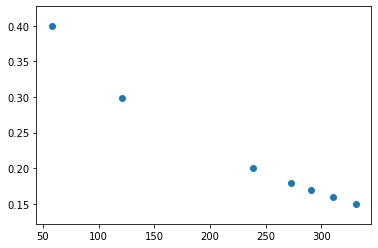

In [10]:
variances = [.6, .7, .8, .82, .83, .84, .85]
print(variances)
dimensions = []
val_mses = []

for variance in tqdm(variances):
    model = PCA(variance).fit(train_relevances)

    reduced_train_relevances = model.transform(train_relevances)
    pred_train_relevances = model.inverse_transform(reduced_train_relevances)

    reduced_val_relevances = model.transform(val_relevances)
    pred_val_relevances = model.inverse_transform(reduced_val_relevances)
    dimensions.append(reduced_val_relevances.shape[1])

    val_mse = np.mean((pred_train_relevances - train_relevances)*(pred_train_relevances - train_relevances))
    val_mses.append(val_mse)
#     print(np.mean((pred_val_relevances - val_relevances)*(pred_val_relevances - val_relevances)))

print(list(zip(variances, dimensions, val_mses)))

plt.scatter(dimensions, val_mses)

# use 0.96875 as variance

In [3]:
# use pca to reduce dimensions with preserved_variance=0.96875 => dim=768 (reduction by 32%), val mse=0.031122472 on scaled data
preserved_variance = 0.80

user_Xs, movie_Xs, ys = get_dataset(train_set, include_ys=True, recompute=False)
train_tags = get_tags(movie_Xs, preserved_variance, recompute=False)

NUM_PROJ_TAGS = train_tags[0].shape[0]
print(f"projected down to {NUM_PROJ_TAGS} dims from {NUM_TAGS} dimensions (reduced by {1-NUM_PROJ_TAGS/NUM_TAGS})")

retrieving dataset from dataset/train_ratings_binary.csv


59360it [00:00, 296372.79it/s]

loading movie tags from csv


11709768it [00:39, 295846.23it/s]


rebuilding pca model preserving 0.8 variance
normalizing
setting default value to average


  4%|▎         | 426826/11946576 [00:00<00:05, 2123746.95it/s]

getting tags


100%|██████████| 11946576/11946576 [00:04<00:00, 2460327.88it/s]

projected down to 228 dims from 1128 dimensions (reduced by 0.7978723404255319)


In [4]:
print(train_tags[:5])


[array([0.19499993, 0.26932433, 0.16548704, 0.30513933, 0.25957322,
       0.31468445, 0.21783373, 0.33380088, 0.32604718, 0.35116148,
       0.24623372, 0.2825228 , 0.27335486, 0.3139616 , 0.3031217 ,
       0.24353845, 0.22127065, 0.2964685 , 0.2799396 , 0.2585362 ,
       0.29813728, 0.25344273, 0.31887996, 0.32067055, 0.27661493,
       0.31390274, 0.2841844 , 0.34395897, 0.30886206, 0.3419188 ,
       0.28596923, 0.3058844 , 0.3279011 , 0.2711107 , 0.27848014,
       0.26054803, 0.29566747, 0.2884222 , 0.32165137, 0.29650766,
       0.30496567, 0.2861339 , 0.28910568, 0.27990335, 0.28922498,
       0.27595046, 0.29772282, 0.28098527, 0.29738665, 0.29211843,
       0.29760945, 0.26875883, 0.2808908 , 0.3021804 , 0.30604818,
       0.283767  , 0.31507048, 0.2733025 , 0.30144453, 0.26626727,
       0.2735752 , 0.2790814 , 0.26703948, 0.29587737, 0.3031414 ,
       0.30196437, 0.30051717, 0.301843  , 0.29942873, 0.30721503,
       0.27768773, 0.29579383, 0.29635638, 0.31578767, 0.2826

print("counting movie percentage that straight up have no tags/movies with at least 1 tag with 0 relevance/total movies")

at_least_a_0 = []
all_0s = []
for i, row in enumerate(tqdm(movie_tag_relevances)):
    if 0 in row:
        at_least_a_0.append(i)
        if sum([1 for e in row if e == 0]) == NUM_TAGS:
            all_0s.append(i)
print("total movies", i+1)
print("movies with at least 1 irrelevant tag", len(at_least_a_0))
print("movies with no tags", len(all_0s))

# CONCLUSION: IF A MOVIE HAS AT LEAST ONE TAG WITH 0 RELEVANCE, THAT MOVIE HAS NO TAG INFO

movies_with_missing_tags = set(get_movies_with_missing_tags())
movieid_mid_lookup = get_movieid_mid_lookup()

def count_na(filename):
    print("counting movie records (will have more movie records than straight up movies) that don't have any tags")
    na_ct, valid_ct = 0, 0
    with open(filename, newline="") as csvfile:
        reader = csv.DictReader(csvfile)
        for rating in tqdm(reader):
            movieid = int(float(rating["movieId"]))
            if movieid_mid_lookup[movieid] in movies_with_missing_tags:
                na_ct += 1
            else:
                valid_ct += 1
    return na_ct, valid_ct

na_ct, valid_ct = count_na(movie_review_relevance)
print(na_ct/(na_ct+valid_ct), " movie_review_relevance entries have no tag info")
na_ct, valid_ct = count_na(movie_genres)
print(na_ct/(na_ct+valid_ct), " movie_genres entries have no tag info")
na_ct, valid_ct = count_na(train_set)
print(na_ct/(na_ct+valid_ct), " train_set entries have no tag info")
na_ct, valid_ct = count_na(val_set)
print(na_ct/(na_ct+valid_ct), " val_set entries have no tag info")
na_ct, valid_ct = count_na(test_set)
print(na_ct/(na_ct+valid_ct), " test_set entries have no tag info")

# CONCLUSION: 61.9% OF ALL MOVIES DON'T HAVE ANY TAG INFO BUT MOST MOVIES THAT ARE FREQUENTLY WATCHED HAVE FULL TAG INFO - ONLY ~3% OF TEST SET MOVIE WATCH ENTRIES HAVE NO TAG INFO

In [51]:
# just verifying the earlier tag analysis

movies_with_missing_tags = get_movies_with_missing_tags()
movieid_mid_lookup = get_movieid_mid_lookup()
movie_tags = np.zeros((NUM_MOVIES, NUM_TAGS), dtype=np.float32)

with open(movie_review_relevance, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        movieid = int(float(rating["movieId"]))
        tagid = int(float(rating["tagId"]))
        relevance = float(rating["relevance"])

        mid = movieid_mid_lookup[movieid]
        tid = tagid_to_tid(tagid)
        movie_tags[mid, tid] = relevance
        if mid in movies_with_missing_tags:
            print(mid, tid, relevance)
            
# conclusion: yeah no tags in movies_with_missing_tags have any tag information - they're not just a bunch of literal 0s in the dataset

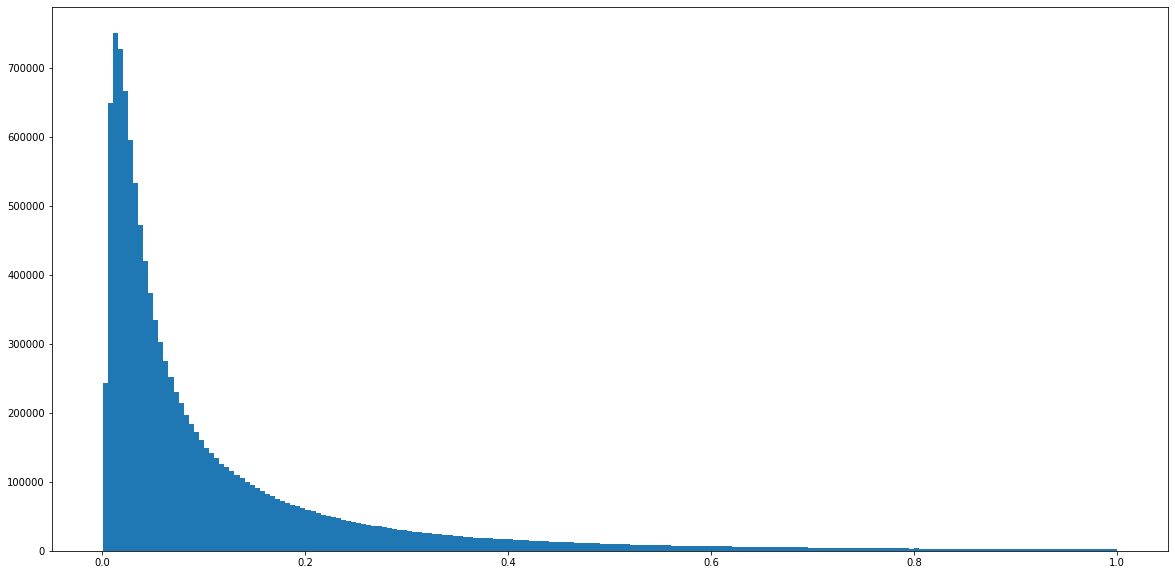

In [19]:
plt.rc('figure', figsize=(20, 10))
plt.hist(movie_tag_relevances.flatten(), bins=200)
plt.show()

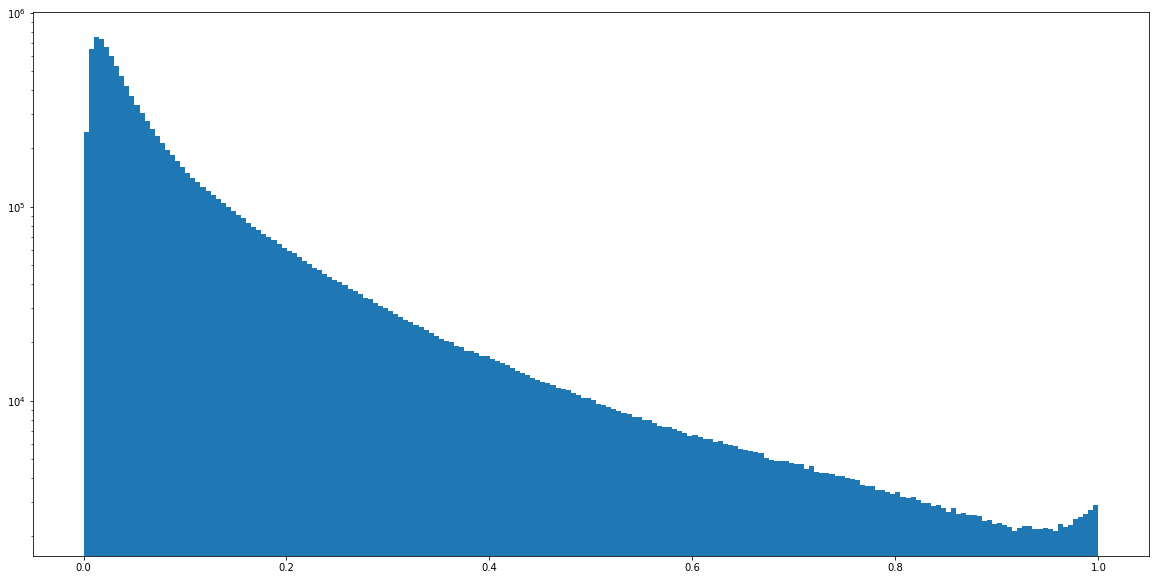

In [20]:
plt.hist(movie_tag_relevances.flatten(), bins=200, log=True)
plt.show()

33414 tags more relevant than .95


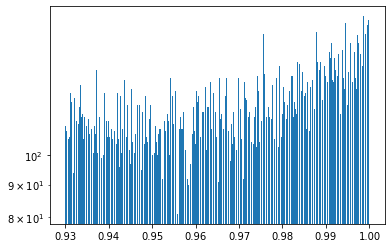

In [31]:
very_relevant = [i for i in movie_tag_relevances.flatten() if i > .93]
print(len(very_relevant), "tags more relevant than .95")
plt.hist(very_relevant, bins=400, log=True)
plt.show()

In [26]:
from collections import defaultdict
cutoff = .95
counts = defaultdict(lambda: 0)

for row in movie_tag_relevances:
    count = len([i for i in row if i > cutoff])
    counts[count] += 1
print(counts)

defaultdict(<function <lambda> at 0x7f95346a7840>, {3: 1205, 17: 3, 2: 1830, 9: 108, 18: 7, 10: 63, 16: 12, 11: 54, 13: 15, 5: 568, 15: 8, 4: 861, 25: 1, 6: 361, 7: 238, 8: 147, 0: 2588, 1: 2261, 22: 2, 19: 3, 14: 12, 12: 29, 23: 2, 21: 2, 20: 1})


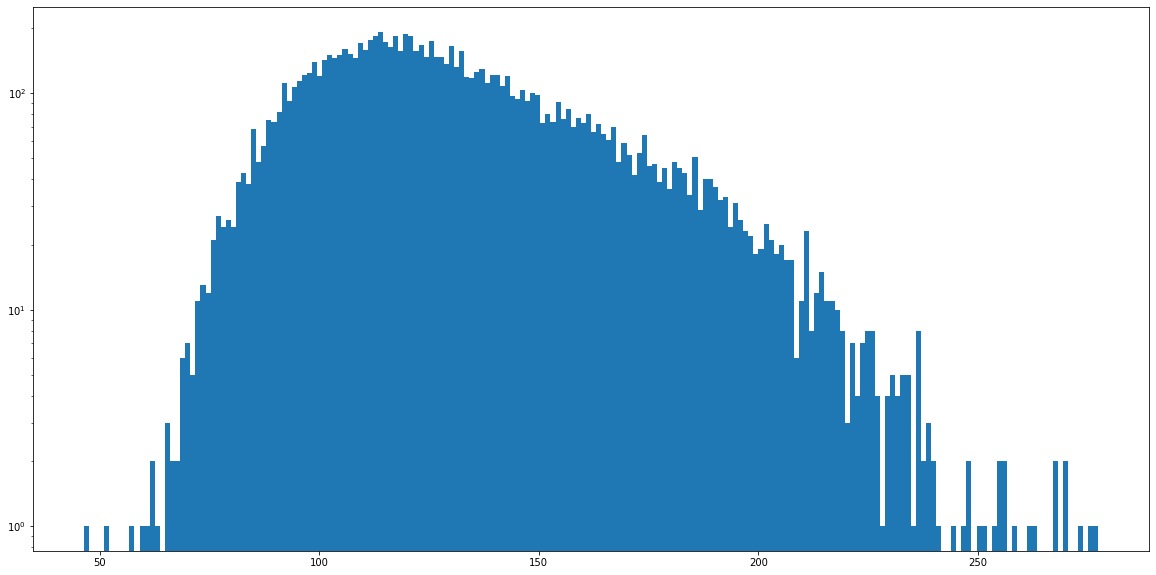

In [21]:
plt.hist([sum(i) for i in movie_tag_relevances], bins=200, log=True)
plt.show()

movies_with_missing_tags = set(get_movies_with_missing_tags())

liked = 0
disliked = 0

with open(train_set, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        movieid = int(float(rating["movieId"]))
        
        if movieid_mid_lookup[movieid] in movies_with_missing_tags:
            if rating["rating"] == "1":
                liked += 1
            else:
                disliked += 1

print(liked, disliked)

# 31.2962495% of movies with no tag information will be disliked

encountered_users = []

with open(train_set, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        userid = int(float(rating["userId"]))
        encountered_users.append(userid)

with open(val_set, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        userid = int(float(rating["userId"]))
        encountered_users.append(userid)

encountered_users = set(encountered_users)

with open(test_set, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        userid = int(float(rating["userId"]))
        if userid not in encountered_users:
            print(f"USERID {userid} NOT ENCOUNTERED IN TRAIN SET BUT IN TEST SET")
            
# all users will have been seen before by training or validation sets.

movieid_mid_lookup = get_movieid_mid_lookup()
with open(test_set, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        movieid = int(float(rating["movieId"]))
        if movieid not in movieid_mid_lookup:
            print(f"MOVIEID {movieid} NOT ENCOUNTERED IN TRAIN SET BUT IN TEST SET")

# all movies will have been seen before by training or validation sets.

In [56]:
reviews = Path("dataset")/"tags_shuffled_rehashed.csv"          # userid/movieid/tag
tag_names = Path("dataset")/"genome-tags.csv"                   # tag name lookup

tag_to_tid = get_tag_to_tid(recompute=True)
missing_tags = defaultdict(lambda: 0)
valid_tags = defaultdict(lambda: 0)
uid_mid_tags = defaultdict(lambda: [])

with open(reviews, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        movieid = int(float(rating["movieId"]))
        userid = int(float(rating["userId"]))
        tag = rating["tag"]
        if tag in tag_to_tid:
            valid_tags[tag] += 1
        else:
            missing_tags[tag] += 1
            
        uid = userid_uid_lookup(userid)
        mid = movieid_mid_lookup[movieid]
        uid_mid_tags[(uid, mid)].append(tag)

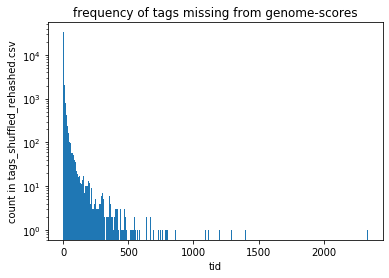

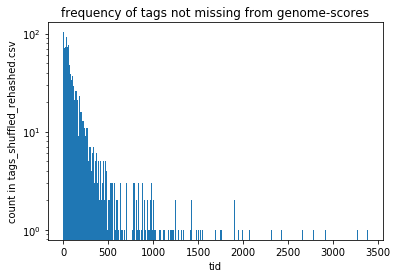

(2334, 'BD-R')


In [81]:
plt.hist([b for a, b in missing_tags.items()], bins=300, log=True)
plt.title("frequency of tags missing from genome-scores")
plt.xlabel("tid")
plt.ylabel("count in tags_shuffled_rehashed.csv")
plt.show()


plt.hist([b for a, b in valid_tags.items()], bins=300, log=True)
plt.title("frequency of tags not missing from genome-scores")
plt.xlabel("tid")
plt.ylabel("count in tags_shuffled_rehashed.csv")
plt.show()

print(max([(b, a) for a, b in missing_tags.items()]))

In [65]:
print(Counter(missing_tags).most_common())

[('BD-R', 2334), ('Nudity (Topless)', 1400), ('Criterion', 1286), ('CLV', 1199), ('World War II', 1116), ('Betamax', 1093), ('DVD-Video', 858), ('Quentin Tarantino', 796), ('Oscar (Best Picture)', 789), ('less than 300 ratings', 780), ('R', 756), ("erlend's DVDs", 740), ('Johnny Depp', 731), ('Disney', 697), ('Brad Pitt', 673), ('Bruce Willis', 671), ("Tumey's DVDs", 645), ('seen more than once', 642), ('Tom Hanks', 587), ('DVD-RAM', 570), ('Morgan Freeman', 554), ('Japan', 553), ('Pixar', 548), ('New York City', 540), ('Nudity (Full Frontal)', 531), ('Nudity (Topless - Brief)', 525), ('Nudity (Topless - Notable)', 518), ('Steven Spielberg', 490), ('Edward Norton', 481), ('movie to see', 477), ('Bill Murray', 473), ('Christian Bale', 471), ('soundtrack', 470), ('Leonardo DiCaprio', 463), ('England', 455), ('Clint Eastwood', 446), ('Tim Burton', 443), ('acting', 442), ('British', 442), ('Samuel L. Jackson', 428), ('Nudity (Full Frontal - Notable)', 419), ('Jim Carrey', 415), ('Tom Cruis

In [52]:
print(Counter(valid_tags).most_common())

[('sci-fi', 3384), ('based on a book', 3281), ('atmospheric', 2917), ('comedy', 2779), ('action', 2657), ('surreal', 2427), ('twist ending', 2323), ('funny', 2072), ('dystopia', 1991), ('stylized', 1941), ('quirky', 1906), ('dark comedy', 1899), ('classic', 1769), ('psychology', 1754), ('fantasy', 1703), ('time travel', 1549), ('romance', 1534), ('visually appealing', 1509), ('disturbing', 1487), ('aliens', 1428), ('thought-provoking', 1422), ('social commentary', 1417), ('violence', 1336), ('drugs', 1312), ('true story', 1276), ('nudity (topless)', 1245), ('adventure', 1243), ('animation', 1229), ('imdb top 250', 1218), ('space', 1199), ('dark', 1194), ('superhero', 1171), ('black comedy', 1126), ('post-apocalyptic', 1116), ('cult film', 1080), ('satire', 1068), ('tense', 1032), ('thriller', 1026), ('drama', 1010), ('predictable', 1008), ('politics', 1000), ('adapted from:book', 991), ('bittersweet', 989), ('horror', 983), ('based on a true story', 977), ('revenge', 972), ('boring', 9

user_Xs, movie_Xs, ys = get_dataset(train_set, include_ys=True, recompute=False)
user_val_Xs, movie_val_Xs, val_ys = get_dataset(val_set, include_ys=True, recompute=False)
user_test_Xs, movie_test_Xs = get_dataset(test_set, include_ys=False, recompute=False)

val_user_movie_has_tag = 0
for uid, mid in tqdm(zip(user_test_Xs, movie_test_Xs)):
    if len(uid_mid_tags[(uid[0], mid[0])]) > 0:
        val_user_movie_has_tag += 1

print(val_user_movie_has_tag/len(user_val_Xs))

# 1.7% of training, .7% of validation and .8% of test set user, movie pairs have tag information

In [110]:
user_Xs, movie_Xs, ys = get_dataset(train_set, include_ys=True, recompute=False)
user_val_Xs, movie_val_Xs, val_ys = get_dataset(val_set, include_ys=True, recompute=False)

uid_mid_rating = {}
for uid, mid, rating in tqdm(chain(zip(user_Xs, movie_Xs, ys), zip(user_val_Xs, movie_val_Xs, val_ys))):
    uid_mid_rating[(uid[0], mid[0])] = 1 if rating[0] > rating[1] else 0

score = 0
num_no_y = 0
total = 0
with open(reviews, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        movieid = int(float(rating["movieId"]))
        userid = int(float(rating["userId"]))
        uid, mid = userid_uid_lookup(userid), movieid_mid_lookup[movieid]
        tag = rating["tag"]
        if tag in {"Bechdel Test:Fail"}:
            if (uid, mid) in uid_mid_rating:
                score += uid_mid_rating[(uid, mid)]
                total += 1
            else:
                num_no_y += 1

retrieving dataset from dataset/train_ratings_binary.csv
retrieving dataset from dataset/val_ratings_binary.csv


In [111]:
print("percentage tags with no y information:", num_no_y/(len(user_Xs)+len(user_val_Xs)))
print(score)
print(total, num_no_y)
print("like percent", score/total)

percentage tags with no y information: 1.0974668458401491e-05
114
191 175
like percent 0.5968586387434555
